<div >
<img src = "../banner.jpg" />
</div>

<a target="_blank" href="https://colab.research.google.com/github/ignaciomsarmiento/ML_UNLP_Lectures/blob/main/Week03/Notebook_Classification_ClassImbalance.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>



# Clasificación

Para trabajar los pasos de clasificación basada en probabilidad, utilizaremos un conjunto de datos reales sobre desempleo de la Encuesta Permanente de Hogares (EPH) de Argentina. Este conjunto de datos incluye variables socioeconómicas y demográficas que nos permitirán predecir si una persona está desempleada o no.  

La predicción del desempleo es un problema clásico de clasificación y sigue siendo una de las áreas clave de aplicación en el aprendizaje automático: usamos información previa sobre la condición laboral de las personas (empleado versus desempleado) para entrenar un modelo que pueda predecir el estado de empleo en nuevos casos.  

\begin{align}
Desempleado_i = f(X_i) + u_i
\end{align}

donde $Desempleado_i$ es una variable dicotómica que toma el valor de 1 si el individuo \( i \) está desempleado y 0 en caso contrario.

In [1]:
# install.packages("pacman") #correr esto en Google Colab

In [2]:
#Cargar librerías 
require("pacman")
p_load("tidyverse",  # Conjunto de paquetes para manipulación, visualización y análisis de datos 
       "caret",       # Herramientas para preprocesamiento, selección de modelos y evaluación de algoritmos de machine learning.
       "glmnet",      # Implementación eficiente de modelos de regresión regularizados (EN, Lasso y Ridge).
       "MLeval",      # Funciones para evaluar modelos de clasificación y regresión con métricas y gráficos.
       "MLmetrics")   # Colección de métricas de evaluación para modelos de machine learning.
       
set.seed(1011)  # Fijar semilla para reproducibilidad de resultados.

# Leer los datos desde un archivo RDS alojado en GitHub
db <- readRDS(url("https://github.com/ignaciomsarmiento/datasets/blob/main/desempelo_arg_2010.Rds?raw=true"))

Loading required package: pacman



Antes de comenzar con el análisis, es fundamental realizar algunas tareas de limpieza y preparación de los datos, comúnmente conocidas como housekeeping. Estas tareas incluyen la filtración de datos para quedarnos con los relevantes, la conversión de variables categóricas a factores sin niveles innecesarios y la recodificación de valores para facilitar la interpretación. A continuación, se detallan los pasos realizados:

In [3]:

# Filtrar los datos para incluir solo observaciones de "Partidos del GBA", "Ciudad de Buenos Aires" y "Gran La Plata"
# Para que sea un poquito más rapido el analisis
db <- db %>% filter(ciudad %in% c("Partidos del GBA", "Ciudad de Buenos Aires", "Gran La Plata"))

# Filtrar niveles vacíos, el siguiente código no funciona porque solo elimina las filas con "Ns./Nr.",  
# pero el nivel sigue existiendo en la estructura del factor.  
# Esto sucede porque R no elimina automáticamente los niveles de un factor al filtrar filas.  
# Un nivel es una categoría posible dentro de una variable de tipo factor, incluso si no tiene observaciones.  
# db <- db %>% filter(nivel_ed != "Ns./Nr.")

# Eliminar niveles vacíos del factor nivel_ed que quedaron después del filtrado
db$nivel_ed <- droplevels(db$nivel_ed)


# Eliminar niveles innecesarios de la variable tipo_vivienda
db$tipo_vivienda <- droplevels(db$tipo_vivienda)

# Eliminar niveles innecesarios de la variable parentesco
db$parentesco <- droplevels(db$parentesco)

# Recodificar la variable tipo_vivienda agrupando ciertas categorías en "Otros"
db <- db %>% mutate(tipo_vivienda = recode(tipo_vivienda,
                                           "Pieza de inquilino" = "Otros",
                                           "Pieza en hotel/pension" = "Otros",
                                           "Local no construido para habitacion" = "Otros"))

# Convertir la variable mujer en un factor con etiquetas más descriptivas (0 = "hombre", 1 = "mujer")
db <- db %>% mutate(mujer = factor(mujer, levels = c(0,1), labels = c("hombre", "mujer")))


In [4]:
head(db)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>
0,31,hombre,Jefe/a,Superior Universitaria Incompleta,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,33,mujer,Conyuge/Pareja,Superior Universitaria Completa,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051
0,54,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,2,0,4000,Departamento,Gran La Plata,1,1251191
0,48,hombre,Jefe/a,Primaria Completa,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,46,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801
0,63,hombre,Jefe/a,Superior Universitaria Incompleta,Casado/a,2,0,3550,Casa,Partidos del GBA,1,1253471


Para entender mejor la distribución del desempleo en nuestro conjunto de datos, calculamos la proporción de individuos desempleados y empleados. La siguiente tabla muestra el porcentaje de observaciones en cada categoría:

Para visualizar la distribución del desempleo en nuestra muestra, generamos un gráfico de barras que muestra la proporción de individuos empleados y desempleados. 

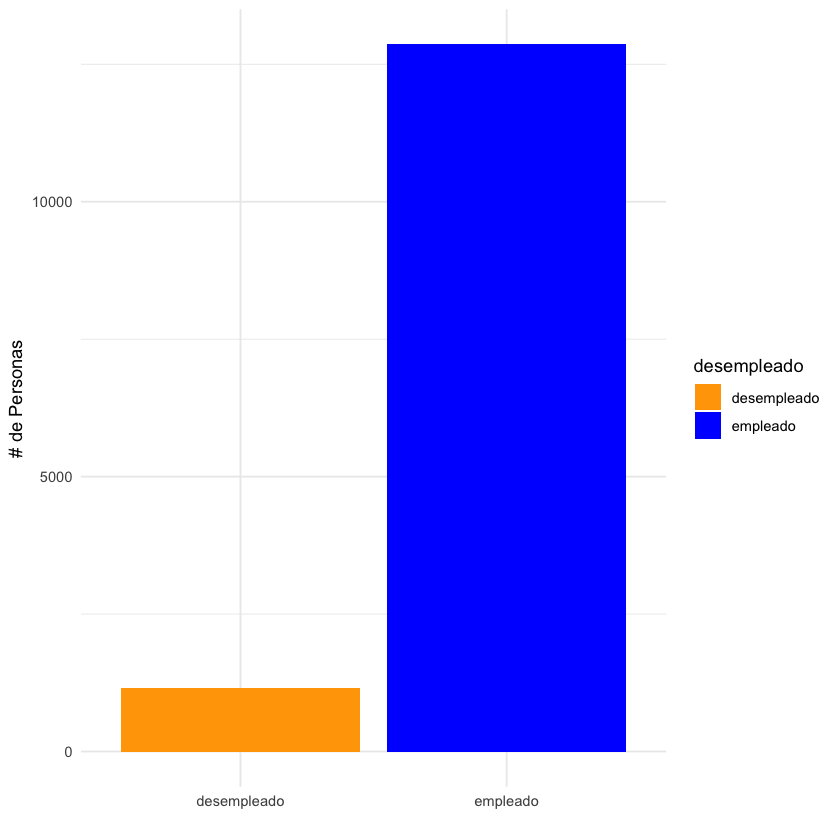

In [5]:
# Convertir la variable desempleado en un factor con etiquetas descriptivas ("desempleado" y "empleado" )
data <- db %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))

# Crear un gráfico de barras con ggplot para visualizar la distribución del desempleo
ggplot(data, aes(x = desempleado, fill = desempleado)) +
  geom_bar() + 
  theme_minimal() +  # Aplicar un tema limpio y sencillo
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) +  # Asignar colores personalizados
  labs(x = "", y = "# de Personas")  



Si tienes un conjunto de datos desbalanceado, lo primero que debes hacer es entrenar el modelo utilizando la distribución real de los datos. Si el modelo funciona bien y generaliza correctamente a nuevos casos, no es necesario hacer ajustes adicionales. Sin embargo, si el modelo no logra un buen desempeño, puedes considerar aplicar algunas estrategias para abordar el desbalance. A continuación, exploraremos algunas soluciones para mejorar la capacidad predictiva del modelo en presencia de clases desbalanceadas.

## Prediciendo el Desempleo en Gran La Plata

Ahora entrenaremos un modelo para predecir el desempleo en Gran La Plata. Para ello, utilizaremos los datos de "Partidos del GBA" y "Ciudad de Buenos Aires" como conjunto de entrenamiento y evaluaremos su desempeño en Gran La Plata, que será nuestra muestra fuera de muestra.

Este enfoque tiene sentido porque Gran La Plata comparte características socioeconómicas y demográficas con estas regiones, lo que sugiere que un modelo entrenado en "Partidos del GBA" y "Ciudad de Buenos Aires" podría generalizar razonablemente bien. Para respaldar esta decisión, exploraremos las estadísticas descriptivas de los predictores clave en las tres regiones.



<div >
<img src = "figs/Aglomerado_Gran_Buenos_Aires.png" />
</div>

In [6]:
p_load("vtable")  # Paquete para generar tablas de resumen descriptivo de forma rápida y visualmente clara

# Crear variable indicadora para Gran La Plata (1) vs. Resto (0) como factor con etiquetas descriptivas
db <- db %>%
  mutate(gran_la_plata = factor(ifelse(ciudad == "Gran La Plata", 1, 0),
                                levels = c(0,1), 
                                labels = c("Resto", "Gran La Plata")))

# Seleccionar variables de interés
variables_interes <- c("gran_la_plata", "edad", "mujer", "nivel_ed", 
                        "parentesco", "estado_civil", "tipo_vivienda", 
                        "ing_tot_fam", "total_miembros_hogar", "miembros_hogar_menores10")

# Generar tabla descriptiva con vtable
vtable::st(db %>% select(all_of(variables_interes)), group = "gran_la_plata", group.test = TRUE)#,out="kable")


## **Predicción Fuera de Muestra (Out-of-Sample Prediction)**  

Para evaluar la capacidad del modelo de generalizar a datos no observados, entrenaremos la función $ f(\cdot) $ utilizando los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**. Luego, aplicaremos esta función aprendida en los datos de **Gran La Plata** y evaluaremos su desempeño.


### **Entrenamiento del Modelo**
Entrenamos el modelo en los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**, estimando:

\begin{align}
\textcolor{blue}{\hat{f}_{\text{train}}} = \arg\min_f \sum_{i \in \textcolor{blue}{\text{train}}} L\big( \textcolor{red}{Desempleado_i}, f(\textcolor{red}{X_i}) \big)
\end{align}

donde:
- $ \textcolor{red}{Desempleado_i} $ es la variable dependiente (1 si el individuo está desempleado, 0 si está empleado).
- $ \textcolor{red}{X_i} $ representa las variables explicativas (edad, género, educación, etc.).
- $ L(\cdot) $ es una función de pérdida que mide el error del modelo en los datos de entrenamiento.
- $ \textcolor{blue}{\hat{f}_{\text{train}}} $ es la función estimada en el conjunto de entrenamiento.

En el caso de Logit 


$$
\textcolor{blue}{\hat{f}_{\text{train}}} = \arg\max_f \sum_{i \in \textcolor{blue}{\text{train}}} \Big[ \textcolor{red}{Desempleado_i} \log f(\textcolor{red}{X_i}) + (1 - \textcolor{red}{Desempleado_i}) \log (1 - f(\textcolor{red}{X_i})) \Big]
$$

donde:
- $ \textcolor{red}{Desempleado_i} $ es la variable dependiente (1 si el individuo está desempleado, 0 si está empleado).
- $ \textcolor{red}{X_i} $ representa las variables explicativas (edad, género, educación, etc.).
- $ f(\textcolor{red}{X_i}) = P(\textcolor{red}{Desempleado_i} = 1 | \textcolor{red}{X_i}) $ es la **probabilidad estimada** de desempleo usando un **modelo logit**.
- $ \textcolor{blue}{\hat{f}_{\text{train}}} $ es la función de regresión logística entrenada en los datos de *Partidos del GBA* y *Ciudad de Buenos Aires*.

### **Predicción/Clasificación  en el Test Set**
Luego, usamos la función estimada $ \textcolor{blue}{\hat{f}_{\text{train}}} $ para calcular la **probabilidad de desempleo** en Gran La Plata:

$$
\hat{p}_i = \textcolor{blue}{\hat{f}_{\text{train}}} (\textcolor{green}{X_i}), \quad \forall i \in \textcolor{green}{\text{test}}
$$

donde $ \hat{p}_i $ **no es una clasificación aún**, sino una probabilidad entre 0 y 1. Para convertirla en una predicción de desempleo o empleo, usamos un umbral:

$$
\hat{y}_i =
\begin{cases} 
1, & \text{si } \hat{p}_i \geq 0.5 \\ 
0, & \text{si } \hat{p}_i < 0.5 
\end{cases}
$$

Así, si la probabilidad estimada de desempleo $ \hat{p}_i $ es mayor o igual a 0.5, clasificamos al individuo como **desempleado** ($ \hat{y}_i = 1 $), y si es menor a 0.5, lo clasificamos como **empleado** ($ \hat{y}_i = 0 $).


## A los datos

In [7]:
# Definir conjunto de entrenamiento (Partidos del GBA y Ciudad de Buenos Aires)
train <- db %>% filter(ciudad %in% c("Partidos del GBA", "Ciudad de Buenos Aires"))

# Definir conjunto de test/prueba/validación (Gran La Plata)
test  <- db %>% filter(ciudad == "Gran La Plata")

- **`train`** se usa para estimar $\textcolor{blue}{\hat{f}_{\text{train}}}$ utilizando los datos de *Partidos del GBA* y *Ciudad de Buenos Aires*.
- **`test`** se usa para evaluar la función estimada en *Gran La Plata* y medir su desempeño.

In [8]:
head(train)

desempleado,edad,mujer,parentesco,nivel_ed,estado_civil,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam,tipo_vivienda,ciudad,trimestre,id_hogar,gran_la_plata
<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<chr>,<fct>
0,31,hombre,Jefe/a,Superior Universitaria Incompleta,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051,Resto
0,33,mujer,Conyuge/Pareja,Superior Universitaria Completa,Unido/a,3,1,8400,Casa,Partidos del GBA,1,1251051,Resto
0,48,hombre,Jefe/a,Primaria Completa,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801,Resto
0,46,mujer,Conyuge/Pareja,Secundaria Incompleta,Casado/a,3,0,3150,Casa,Partidos del GBA,1,1251801,Resto
0,63,hombre,Jefe/a,Superior Universitaria Incompleta,Casado/a,2,0,3550,Casa,Partidos del GBA,1,1253471,Resto
0,50,hombre,Jefe/a,Superior Universitaria Completa,Casado/a,3,0,3500,Casa,Partidos del GBA,1,1254331,Resto


In [9]:
prop.table(table(train$desempleado))


         0          1 
0.91538079 0.08461921 

In [10]:
prop.table(table(test$desempleado))


         0          1 
0.93020886 0.06979114 

### Entrenamiento del Modelo con Logit 
$$
\textcolor{blue}{\hat{f}_{\text{train}}} = \arg\max_f \sum_{i \in \textcolor{blue}{\text{train}}} \Big[ \textcolor{red}{Desempleado_i} \log f(\textcolor{red}{X_i}) + (1 - \textcolor{red}{Desempleado_i}) \log (1 - f(\textcolor{red}{X_i})) \Big]
$$

Comenzamos con un modelo simple

In [11]:
ctrl<- trainControl(method = "cv",
                    number = 5,
                    classProbs = TRUE,
                    verbose=FALSE,
                    savePredictions = T)


In [12]:
# Me guardo la variable numerica, por las dudas
train <- train %>% mutate(desempleado_num =desempleado)
test  <- test  %>% mutate(desempleado_num =desempleado)

# # Clave que "desempleado" sea el primer nivel
train <- train %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))
test  <- test  %>% mutate(desempleado = factor(desempleado, levels = c(1,0), labels = c("desempleado","empleado")))


In [13]:
prop.table(table(train$desempleado))


desempleado    empleado 
 0.08461921  0.91538079 

In [14]:
set.seed(1410)
mylogit_caret <- train(desempleado~edad+mujer+nivel_ed+ parentesco +
                        estado_civil+tipo_vivienda+ing_tot_fam+total_miembros_hogar+miembros_hogar_menores10,
                       data = train, 
                       method = "glm",
                       trControl = ctrl,
                       family = "binomial")


mylogit_caret

Generalized Linear Model 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9643, 9643, 9643, 9643, 9644 
Resampling results:

  Accuracy   Kappa     
  0.9151319  0.01392964


#### Predicción/Clasificación  en el Test Set del modelo anterior

$$
\hat{p}_i = \textcolor{blue}{\hat{f}_{\text{train}}} (\textcolor{green}{X_i}), \quad \forall \textcolor{green}{i \in \text{test}}
$$


donde $ \hat{p}_i $ **no es una clasificación aún**, sino una probabilidad entre 0 y 1. Para convertirla en una predicción de desempleo o empleo, usamos un umbral:

$$
\textcolor{green}{\hat{y}_i} =
\begin{cases} 
1, & \text{si } \hat{p}_i \geq 0.5 \\ 
0, & \text{si } \hat{p}_i < 0.5 
\end{cases}
$$

Así, si la probabilidad estimada de desempleo $ \hat{p}_i $ es mayor o igual a 0.5, clasificamos al individuo como **desempleado** ($ \textcolor{green}{\hat{y}_i} = 1 $), y si es menor a 0.5, lo clasificamos como **empleado** ($ \textcolor{green}{\hat{y}_i} = 0 $) (Regla de Bayes).

In [15]:
predictTest_logit <- data.frame(
  obs = test$desempleado,                                    ## observed class labels
  predict(mylogit_caret, newdata = test, type = "prob"),         ## predicted class probabilities
  pred = predict(mylogit_caret, newdata = test, type = "raw")    ## predicted class labels
)


In [16]:
head(predictTest_logit)

,obs,desempleado,empleado,pred
,<fct>,<dbl>,<dbl>,<fct>
1,empleado,0.07832292,0.9216771,empleado
2,empleado,0.04846411,0.9515359,empleado
3,empleado,0.20591050,0.7940895,empleado
4,empleado,0.04280675,0.9571933,empleado
5,empleado,0.08620709,0.9137929,empleado
6,empleado,0.06601790,0.9339821,empleado


## **Evaluación: Comparación de Predicciones y Valores Reales**  

Para validar el desempeño del modelo, compararemos las predicciones $ \textcolor{green}{\hat{y}_i} $ con los valores reales $\textcolor{red}{y_i}  $ en el conjunto de prueba.  

Donde:

- $ \textcolor{green}{\hat{y}_i} $ es la clasificación predicha por el modelo.
- $ \textcolor{red}{y_i} $ es el estado real de empleo/desempleo en Gran La Plata.


Para ver el desempeño analizaremos las métricas de desempeño

### Un modelo logit simple

In [17]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_orig=predict(mylogit_caret,newdata = test,
                           type = "raw"))

In [18]:
# Matriz de Confusión
cm_logit_orig<-confusionMatrix(data = test$desempleo_hat_logit_orig, 
                reference = test$desempleado, 
                positive="desempleado", 
                mode = "prec_recall")
cm_logit_orig

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           3        2
  empleado            134     1824
                                          
               Accuracy : 0.9307          
                 95% CI : (0.9186, 0.9416)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.4874          
                                          
                  Kappa : 0.0375          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.600000        
                 Recall : 0.021898        
                     F1 : 0.042254        
             Prevalence : 0.069791        
         Detection Rate : 0.001528        
   Detection Prevalence : 0.002547        
      Balanced Accuracy : 0.510401        
                                          
       'Positive' Class : desempleado     
                      

In [19]:
# guardo en un data frame
df_logit1 <- data.frame(
  Model = "Logit1",
  Accuracy = cm_logit_orig$overall["Accuracy"],
  Precision = cm_logit_orig$byClass["Precision"],
  Recall = cm_logit_orig$byClass["Recall"],
  F1_Score = cm_logit_orig$byClass["F1"]
)

#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit1)<-NULL
df_logit1

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6,0.02189781,0.04225352


### Un modelo logit con mayor complejidad y Trade off Sesgo-Varianza  

In [20]:
X <- c("poly(edad,2,raw=TRUE)", "nivel_ed","mujer", 
        "parentesco", "estado_civil", 
        "tipo_vivienda",
        "poly(total_miembros_hogar,2,raw=TRUE)",
        "poly(miembros_hogar_menores10,2,raw=TRUE)",
        "poly(ing_tot_fam,2,raw=TRUE)")


set.seed(1410)
glm_model_logit_ampliado <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = train,
    family = "binomial",
    trControl = ctrl,
    preProcess = c("center", "scale")
  )

# Si aparece "glm.fit: algorithm did not converge", puede haber colinealidad o separación perfecta.
# Si aparece "glm.fit: fitted probabilities numerically 0 or 1 occurred", algunas predicciones son extremas (0 o 1). Esto provoca coeficientes muy grandes (explosivos) en la regresión logística.
# Para mitigar estos problemas, prueba eliminar predictores redundantes o usar regularización (glmnet) next.

Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: algorithm did not converge”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [21]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_ampliado=predict(glm_model_logit_ampliado,newdata = test,
                           type = "raw"))

In [22]:
# Matriz de Confusión
cm_logit_ampliado<-confusionMatrix(data = test$desempleo_hat_logit_ampliado, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_logit_ampliado

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          20       26
  empleado            117     1800
                                          
               Accuracy : 0.9272          
                 95% CI : (0.9148, 0.9383)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.7205          
                                          
                  Kappa : 0.1902          
                                          
 Mcnemar's Test P-Value : 5.225e-14       
                                          
              Precision : 0.43478         
                 Recall : 0.14599         
                     F1 : 0.21858         
             Prevalence : 0.06979         
         Detection Rate : 0.01019         
   Detection Prevalence : 0.02343         
      Balanced Accuracy : 0.56587         
                                          
       'Positive' Class : desempleado     
                      

In [23]:
# guardo en un data frame
df_logit2 <- data.frame(
  Model = "Logit2",
  Accuracy = cm_logit_ampliado$overall["Accuracy"],
  Precision = cm_logit_ampliado$byClass["Precision"],
  Recall = cm_logit_ampliado$byClass["Recall"],
  F1_Score = cm_logit_ampliado$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit2)<-NULL

# Ver los resultados
df_logit2

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit2,0.9271523,0.4347826,0.1459854,0.2185792


In [24]:
# Comparamos
metrics_df <- rbind(df_logit1, df_logit2)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923


### Elastic Net y Trade off Sesgo-Varianza de forma empírica

Ajustemos ahroa un Elastic Net que minimiza la siguiente función de pérdida. En este caso combinamos la verosimilitud de una regresión logística con una penalización sobre los coeficientes:

$$
E(\beta) = - \frac{1}{N} \sum_{i=1}^{N} \left[ y_i \log \hat{p}_i + (1 - y_i) \log (1 - \hat{p}_i) \right] + \lambda \left( \alpha \sum_{j} |\beta_j| + (1 - \alpha) \sum_{j} \beta_j^2 \right)
$$

donde:
- El primer término es la **log-verosimilitud** de la regresión logística.
- El segundo término es la **penalización** de regularización.
  - $\sum |\beta_j|$ es la norma $L_1$ (Lasso), que induce **sparsidad** y selecciona variables.
  - $\sum \beta_j^2$ es la norma $L_2$ (Ridge), que **disminuye la varianza** sin eliminar variables.
- $\lambda$ controla la **complejidad del modelo**:
  - Si $\lambda$ es grande, los coeficientes $\beta$ se acercan a cero (reduciendo la complejidad).
  - Si $\lambda$ es pequeño, el modelo se parece más a una regresión logística estándar (mayor flexibilidad).


El ajuste de este modelo nos ayuda a hacer un balance entre sesgo y varianza:

1. **Modelos sin regularización (baja $\lambda$)**  
   - Tienen **baja restricción** sobre los coeficientes $\beta$.
   - Son **flexibles**, capaces de captar patrones complejos.
   - Pero pueden **sobreajustar** los datos, aumentando la varianza y el riesgo de mal generalización en datos nuevos.

2. **Modelos con alta regularización (alta $\lambda$)**  
   - Tienen **coeficientes más pequeños** (incluso algunos en cero si usamos Lasso).
   - Son **simples**, lo que **reduce la varianza** pero introduce **sesgo**.
   - Si $\lambda$ es demasiado alto, el modelo puede **subajustar**, perdiendo relaciones importantes.

El **Elastic Net** ($0 < \alpha < 1$) busca un **balance entre estos extremos**, combinando Lasso y Ridge para reducir la varianza sin eliminar demasiadas variables importantes.


Voy a especificar los siguientes predictores:

In [25]:
X <- c("poly(edad,2,raw=TRUE)",  # Polinomio de grado 2 para la edad (captura relaciones no lineales)
       "nivel_ed",  # Nivel educativo (puede ser categórico u ordinal)
       "mujer",  # Indicador de género (1 = mujer, 0 = hombre)
       "parentesco",  # Relación con el jefe/a de hogar (variable categórica)
       "estado_civil",  # Estado civil (soltero, casado, divorciado, etc.)
       "tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE)",  # INTERACCIÓN entre tipo de vivienda y polinomio de tamaño del hogar
       "poly(miembros_hogar_menores10,2,raw=TRUE)",  # Polinomio de grado 2 del número de niños menores de 10 años en el hogar
       "poly(ing_tot_fam,2,raw=TRUE)")  # Polinomio de grado 2 del ingreso total familiar

# Diferencia entre : y * en fórmulas de modelos en R:
# - `:` (dos puntos) indica solo la INTERACCIÓN entre dos variables, sin incluir sus efectos principales.
#   Ejemplo: `mujer:estado_civil` modela la interacción entre `mujer` y `estado_civil`, pero NO incluye `mujer` ni `estado_civil` como términos independientes.
# - `*` (asterisco) incluye la INTERACCIÓN Y los efectos principales de las variables involucradas.
#   Ejemplo: `mujer * estado_civil` equivale a `mujer + estado_civil + mujer:estado_civil`.


**¿Por qué `EN` en esta especificación de \(X\)?**
- **Alta complejidad inicial:** Se incluyen polinomios (`poly(...)`), interacciones (`*`), y variables categóricas (`nivel_ed`, `parentesco`). Esto crea un espacio de predictores potencialmente **muy grande** y **colineal**.
- **Evitar sobreajuste:** Sin regularización, el modelo podría **ajustarse demasiado a los datos de entrenamiento**, capturando ruido en lugar de relaciones genuinas.
- **Reducir colinealidad:** Ridge ayuda a manejar **multicolinealidad**, mientras que Lasso puede seleccionar **las variables más importantes**.
- **Optimización de sesgo-varianza:** La grilla de $\lambda$ y $\alpha$ nos permite encontrar un modelo que **ni subajuste ni sobreajuste**.

In [26]:
# Definición de la grilla de hiperparámetros (esta es solo un ejemplo para ejecutar en clase, en la practica la grilla tiene que ser mucho mas fina)
lambda <- 10^seq(1, -4, length = 100)  # Genera una secuencia de valores de lambda para la regularización
grid <- expand.grid("alpha" = seq(0,1,by=0.25), lambda = lambda)   # Crea una grilla de hiperparámetros para la búsqueda


set.seed(1410)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.
glm_model_en <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),  # Construcción de la fórmula del modelo
    method = "glmnet",  # Usa glmnet para regresión con regularización (EN)
    data = train,  # Usa los datos de entrenamiento
    family = "binomial",  # Es un modelo logístico (para clasificación binaria)
    tuneGrid = grid,  # Especifica la grilla de hiperparámetros
    preProcess = c("center", "scale"),  # Normaliza las variables predictoras,
    maxit=5000 # usar el default, esto es para que corra mas rapido en clase
)


glm_model_en
# Warning "Convergence for XXXth lambda value not reached" indica que glmnet no encontró una solución estable para ese lambda.
# Puede deberse a colinealidad, separación perfecta, y datos no balanceados.

Warning message:
“from glmnet C++ code (error code -37); Convergence for 37th lambda value not reached after maxit=5000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -92); Convergence for 92th lambda value not reached after maxit=5000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -38); Convergence for 38th lambda value not reached after maxit=5000 iterations; solutions for larger lambdas returned”


glmnet 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 12054, 12054, 12054, 12054, 12054, 12054, ... 
Resampling results across tuning parameters:

  alpha  lambda        Accuracy   Kappa        
  0.00   1.000000e-04  0.9148596   6.475900e-03
  0.00   1.123324e-04  0.9148596   6.475900e-03
  0.00   1.261857e-04  0.9148596   6.475900e-03
  0.00   1.417474e-04  0.9148596   6.475900e-03
  0.00   1.592283e-04  0.9148596   6.475900e-03
  0.00   1.788650e-04  0.9148596   6.475900e-03
  0.00   2.009233e-04  0.9148596   6.475900e-03
  0.00   2.257020e-04  0.9148596   6.475900e-03
  0.00   2.535364e-04  0.9148596   6.475900e-03
  0.00   2.848036e-04  0.9148596   6.475900e-03
  0.00   3.199267e-04  0.9148596   6.475900e-03
  0.00   3.593814e-04  0.9148596   6.475900e-03
  0.00   4.037017e-04  0.9148596   6.475900e-03
  0.00   4.534879e-04  0.9148596   6.475900e-03


In [27]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_en=predict(glm_model_en,newdata = test,
                           type = "raw"))


In [28]:
# Matriz de Confusión
cm_logit_EN <- confusionMatrix(data = test$desempleo_hat_logit_en, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_logit_EN 

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           0        0
  empleado            137     1826
                                         
               Accuracy : 0.9302         
                 95% CI : (0.918, 0.9411)
    No Information Rate : 0.9302         
    P-Value [Acc > NIR] : 0.5227         
                                         
                  Kappa : 0              
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
              Precision :      NA        
                 Recall : 0.00000        
                     F1 :      NA        
             Prevalence : 0.06979        
         Detection Rate : 0.00000        
   Detection Prevalence : 0.00000        
      Balanced Accuracy : 0.50000        
                                         
       'Positive' Class : desempleado    
                                         

In [29]:
# guardo en un data frame
df_logit_EN <- data.frame(
  Model = "Logit_EN",
  Accuracy = cm_logit_EN$overall["Accuracy"],
  Precision = cm_logit_EN$byClass["Precision"],
  Recall = cm_logit_EN$byClass["Recall"],
  F1_Score = cm_logit_EN$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_EN)<-NULL

# Ver los resultados
df_logit_EN

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit_EN,0.9302089,NA,0,NA


In [30]:
# Comparamos
metrics_df <- rbind(metrics_df, df_logit_EN)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA


## Curva ROC: Trade-Off entre puntos de corte de clasificación

\begin{align}
\hat{y}_i=1[p_i\geq c] \nonumber
\end{align}

***MLeval: Machine Learning Model Evaluation***

Input: caret train function object

Not averaging probs.

Group 1 type: cv

Group 2 type: cv

Observations: 24108

Number of groups: 2

Observations per group: 12054

Positive: empleado

Negative: desempleado

Group: Basic

Positive: 11034

Negative: 1020

Group: Ampliado

Positive: 11034

Negative: 1020

***Performance Metrics***

Basic Optimal Informedness = 0.39231466376654

Ampliado Optimal Informedness = 0.320902771113883

Basic AUC-ROC = 0.76

Ampliado AUC-ROC = 0.67



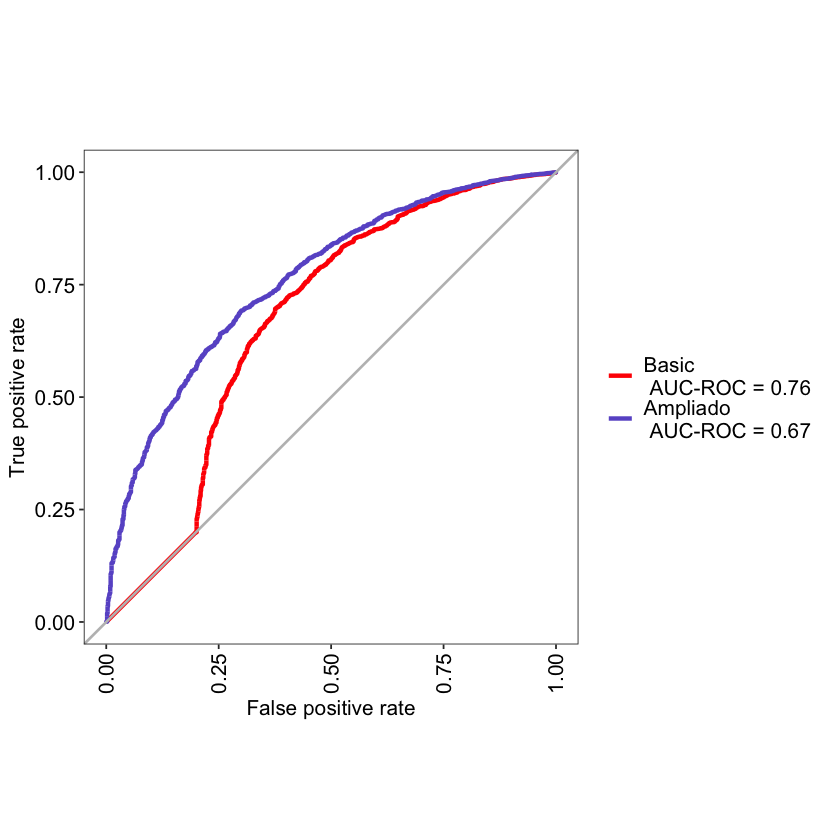

In [31]:
#Curva ROC
res_insample_all <- evalm(list(mylogit_caret, glm_model_logit_ampliado),gnames=c('Basic','Ampliado'),plots='r')

# Desbalance de Clases

Hasta ahora, hemos entrenado un modelo logit utilizando los datos de **Partidos del GBA** y **Ciudad de Buenos Aires**, y lo hemos aplicado a **Gran La Plata** para evaluar su capacidad predictiva. Sin embargo, antes de interpretar los resultados, es fundamental examinar un problema que hemos identificado previamente: el **desbalance de clases** en la variable de desempleo.  

El desbalance de clases ocurre cuando una de las categorías de la variable objetivo  es mucho más frecuente que la otra. En nuestro caso, es probable que la cantidad de personas empleadas sea significativamente mayor que la cantidad de personas desempleadas:

$$
P(Desempleado_i = 1) \ll P(Desempleado_i = 0)
$$

donde:
- $ P(Desempleado_i = 1) $ es la proporción de individuos desempleados.
- $ P(Desempleado_i = 0) $ es la proporción de individuos empleados.



**¿Por qué es un problema?**  
Cuando un modelo de clasificación enfrenta un conjunto de datos desbalanceado, puede **aprender a favorecer la clase mayoritaria** (empleados) y predecir muy pocos casos de la clase minoritaria (desempleados). Esto puede llevar a una alta **precisión global engañosa**, donde el modelo parece acertar la mayoría de los casos simplemente porque predice "empleado" casi siempre.  

Antes de aplicar estrategias correctivas, vamos a analizar **cuán desbalanceados están nuestros datos**. Para ello, observaremos la proporción de empleados y desempleados en el conjunto de entrenamiento y de prueba.



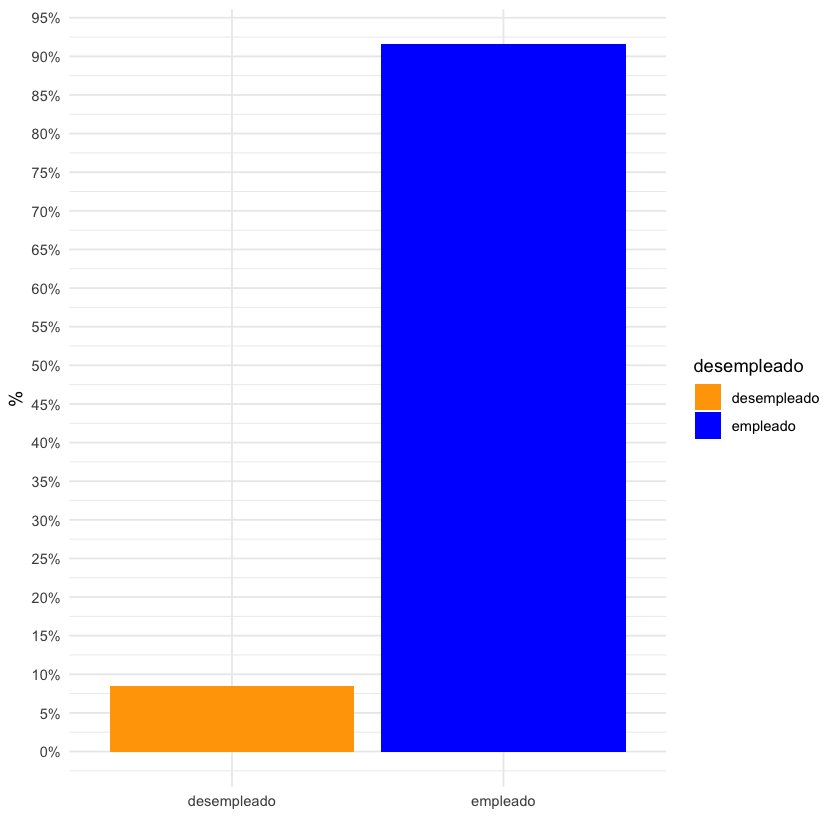

In [32]:
# Train Set
ggplot(train,aes(x = desempleado, y = after_stat(count / sum(count)), fill = desempleado)) +
  geom_bar() +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(), breaks = seq(0, 1, by = 0.05)) +  
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + 
   labs(x = "", y = "%")  

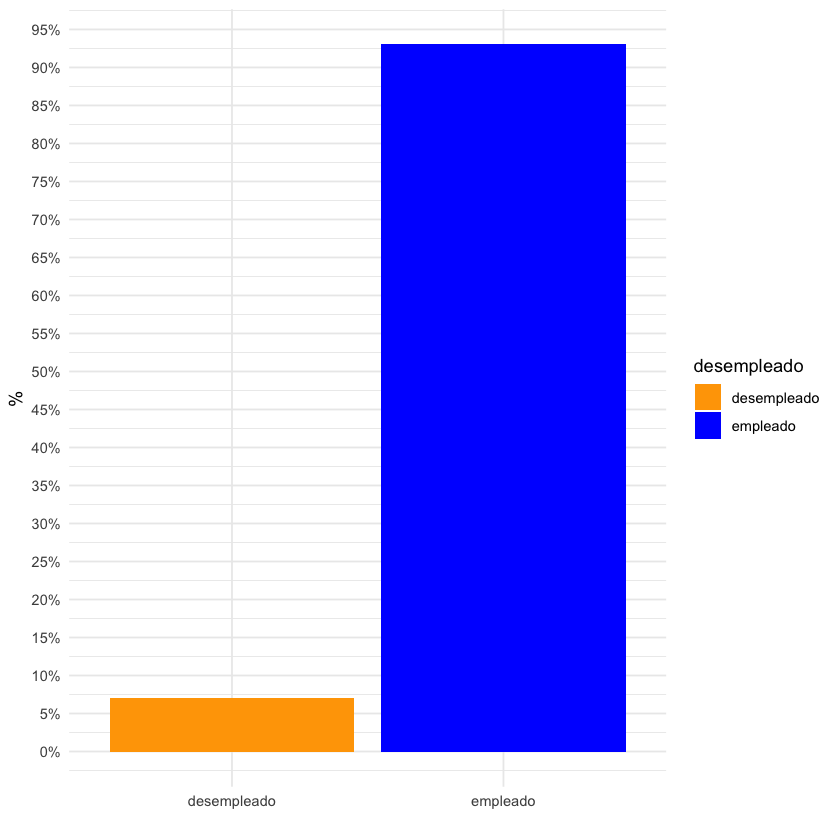

In [33]:
# Test Set
ggplot(test,aes(x = desempleado, y = after_stat(count / sum(count)), fill = desempleado)) +
  geom_bar() +
  theme_minimal() +
  scale_y_continuous(labels = scales::percent_format(), breaks = seq(0, 1, by = 0.05)) +  
  scale_fill_manual(values = c("desempleado" = "orange", "empleado"= "blue")) + 
   labs(x = "", y = "%")  

## Grado de Desbalance


| Grado de Desbalance | Proporción de la Clase Minoritaria  |
|--------------------|----------------------------------|
| Leve             | 20-40% de los datos     |
| Moderado         | 1-20% de los datos     |
| Extremo          | <1% de los datos     |

### Métricas -> Slides


## Estrategias para Manejar el Desbalance de Clases  

El desbalance de clases puede afectar la capacidad del modelo para identificar correctamente la clase minoritaria (desempleados). Para mitigar este problema, consideraremos cinco estrategias principales:  

### Ajuste del Modelo (*Model Tuning*)  
Optimizar el modelo o  los hiperparámetros del modelo para mejorar su capacidad de detectar la clase minoritaria. En el caso de regresión logística, esto puede incluir:  
- Ajustar las variables explicativas.
- **Cambiar la métrica objetivo**, por ejemplo, podemos priorizar el *Recall* o *sensibilidad* en lugar de precisión global, de manera que el modelo maximice la tasa de verdaderos positivos (personas desempleadas bien clasificadas).  

### Modificación del Umbral de Clasificación (*Alternative Cutoffs*)  
El umbral estándar de **0.5** puede ser inadecuado para datos desbalanceados. Podemos:  
- **Reducir el umbral** (ej. 0.3) para clasificar más casos como desempleados, aumentando la sensibilidad.  
- **Ajustar el umbral en función de métricas como la curva ROC o el F1-score**, balanceando precisión y sensibilidad.  


### Rebalanceo de Clases (*Class Rebalancing*)  
Modificar la composición del conjunto de entrenamiento para hacer que el modelo aprenda con un dataset más equilibrado:  
-  **Reponderar Observaciones**:  asignar **mayor peso** a la clase minoritaria. Esto obliga al modelo a prestar más atención a los casos de desempleo y **reduce el sesgo hacia la clase mayoritaria**.  
- **Submuestreo**: Reducir el número de observaciones de la clase mayoritaria (empleados), para evitar que dominen el aprendizaje.  
- **Sobremuestreo**: Aumentar artificialmente la cantidad de observaciones de la clase minoritaria (ej. replicando casos de desempleo).  
- **Técnicas avanzadas** como **SMOTE (Synthetic Minority Over-sampling Technique)**, que genera ejemplos sintéticos en la clase minoritaria en lugar de simplemente replicarlos.  



## **Ajuste del Modelo (*Model Tuning*)**  

Una de las formas más directas de contrarrestar los efectos negativos del **desbalance de clases** es **ajustar el modelo** para que maximice la precisión en la clase minoritaria (**los desempleados**). En este caso, en lugar de optimizar la precisión general del modelo, **maximizaremos la sensibilidad (recall)**, asegurándonos de capturar la mayor cantidad posible de casos de desempleo.  

Para ello, realizaremos los siguientes ajustes en el modelo:  
1. **Definir una función de evaluación personalizada**, que incluya métricas clave como sensibilidad, precisión y la métrica F1.  
2. **Optimizar los hiperparámetros** del modelo de regresión logística regularizada, buscando la mejor combinación de penalización Lasso/Ridge para maximizar la sensibilidad.  



In [34]:
multiStats <- function(...) c(twoClassSummary(...), defaultSummary(...), prSummary(...))


# `twoClassSummary(...)`: Calcula métricas específicas para clasificación binaria, como AUC, sensibilidad y especificidad.  
# `defaultSummary(...)`: Incluye métricas generales como precisión.  
# `prSummary(...)`: Agrega métricas basadas en precisión y recall, útiles para datos desbalanceados.  


ctrl_multiStats <- trainControl(
  method = "cv",  # Usamos validación cruzada
  number = 5,  # 5-fold cross-validation
  summaryFunction = multiStats,  # Usamos la función de evaluación personalizada
  classProbs = TRUE,  # Habilita el cálculo de probabilidades para cada clase
  verbose = FALSE,  # Evita mensajes innecesarios en la consola
  savePredictions = TRUE  # Guarda las predicciones para análisis posterior
    )

In [35]:
set.seed(1410)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.

glm_model_en_sens <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),  # Construcción de la fórmula del modelo
    method = "glmnet",  # Usa glmnet para regresión con regularización (Lasso/Ridge)
    data = train,  # Usa los datos de entrenamiento
    family = "binomial",  # Es un modelo logístico (para clasificación binaria)
    tuneGrid = grid,  # Especifica la cuadrícula de hiperparámetros
    preProcess = c("center", "scale"),  # Normaliza las variables predictoras
    trControl = ctrl_multiStats,  # Control del entrenamiento y validación cruzada
    metric = "Sens"  # Optimiza la métrica de sensibilidad (recall para la clase positiva)
)
glm_model_en_sens  

Warning message:
“from glmnet C++ code (error code -38); Convergence for 38th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message:
“from glmnet C++ code (error code -39); Convergence for 39th lambda value not reached after maxit=100000 iterations; solutions for larger lambdas returned”
Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
“There were missing values in resampled performance measures.”


glmnet 

12054 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 9643, 9643, 9643, 9643, 9644 
Resampling results across tuning parameters:

  alpha  lambda        ROC        Sens          Spec       Accuracy 
  0.00   1.000000e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   1.123324e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   1.261857e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   1.417474e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   1.592283e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   1.788650e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   2.009233e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   2.257020e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   2.535364e-04  0.7629315  0.0039215686  0.9993656  0.9151320
  0.00   2.848036e-04  0.7629315  0.003921568

In [36]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "raw"))

In [37]:
# Matriz de Confusión
cm_logit_EN_SENS <- confusionMatrix(data = test$desempleo_hat_logit_en_sens, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_logit_EN_SENS

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado           6        0
  empleado            131     1826
                                          
               Accuracy : 0.9333          
                 95% CI : (0.9213, 0.9439)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 0.3165          
                                          
                  Kappa : 0.0785          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 1.000000        
                 Recall : 0.043796        
                     F1 : 0.083916        
             Prevalence : 0.069791        
         Detection Rate : 0.003057        
   Detection Prevalence : 0.003057        
      Balanced Accuracy : 0.521898        
                                          
       'Positive' Class : desempleado     
                      

In [38]:
# guardo en un data frame
df_logit_EN_SENS <- data.frame(
  Model = "Logit_EN_Recall",
  Accuracy = cm_logit_EN_SENS$overall["Accuracy"],
  Precision = cm_logit_EN_SENS$byClass["Precision"],
  Recall = cm_logit_EN_SENS$byClass["Recall"],
  F1_Score = cm_logit_EN_SENS$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_EN_SENS)<-NULL

# Ver los resultados
df_logit_EN_SENS

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit_EN_Recall,0.9332654,1,0.04379562,0.08391608


In [39]:
# Comparamos
metrics_df <- rbind(metrics_df, df_logit_EN_SENS)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608


## Modificación del Umbral de Clasificación (*Alternative Cutoffs*)  

Cuando hay dos categorías posibles en la variable de respuesta, una estrategia efectiva para mejorar la precisión en la predicción de la **clase minoritaria** es ajustar el **umbral de clasificación**. En un modelo de regresión logística, la predicción es una **probabilidad**, y el umbral estándar de **0.5** puede no ser óptimo cuando los datos están desbalanceados.  

Al modificar este umbral, podemos **cambiar la definición de un evento positivo (desempleado)**, ajustando la tasa de **falsos positivos (FP)** y **verdaderos positivos (TP)** del modelo. Para encontrar el umbral óptimo, utilizaremos la **curva ROC (Receiver Operating Characteristic)** y seleccionaremos un punto de corte que logre un equilibrio entre detectar la mayor cantidad posible de desempleados (TP) sin aumentar excesivamente las falsas alarmas (FP).  

In [40]:
p_load("pROC") # Paquete para calcular y visualizar curvas ROC

roc_obj_en<-roc(response=glm_model_en_sens$pred$obs[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda],  # Valores reales de la variable objetivo
                   predictor=glm_model_en_sens$pred$desempleado[glm_model_en_sens$pred$lambda==glm_model_en_sens$bestTune$lambda], # Probabilidades predichas por el modelo
                  levels = c("empleado", "desempleado"),  # # Establece la referencia control y caso (empleado = negativo, desempleado = positivo) 
                  direction = "<")  # "<" significa que "desempleado" es positivo

Este objeto nos almacena la curva ROC del modelo. Con este deterimemos el Mejor Punto de Corte

In [41]:
rfThresh_en <- coords(roc_obj_en, x = "best", best.method = "closest.topleft")
rfThresh_en

threshold,specificity,sensitivity
<dbl>,<dbl>,<dbl>
0.08086415,0.6711437,0.7221569


`threshold` es el **nuevo umbral de clasificación** en lugar de 0.5.  

**¿Por qué hacemos esto?**  
- Un umbral más bajo **aumenta los verdaderos positivos (TP)**, reduciendo el riesgo de clasificar desempleados como empleados.  
- Un umbral más bajo también **puede aumentar los falsos positivos (FP)**, es decir, clasificar algunos empleados como desempleados.  
- Buscamos un **balance** donde mejoremos la detección de desempleados sin generar demasiadas falsos positivos. 

In [42]:
# Evaluando en el Test Set aplicando el nuevo umbral
test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens,newdata = test,
                           type = "prob")$desempleado)

# Clasificamos los Casos Usando el Nuevo Umbral
test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff=factor(ifelse(desempleo_prob_logit_en_sens>=rfThresh_en$threshold,1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))

In [43]:
# Matriz de Confusión
cm_logit_en_sens_cutoff <- confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_logit_en_sens_cutoff

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         105      537
  empleado             32     1289
                                          
               Accuracy : 0.7101          
                 95% CI : (0.6895, 0.7301)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1746          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.16355         
                 Recall : 0.76642         
                     F1 : 0.26958         
             Prevalence : 0.06979         
         Detection Rate : 0.05349         
   Detection Prevalence : 0.32705         
      Balanced Accuracy : 0.73617         
                                          
       'Positive' Class : desempleado     
                      

In [44]:
# guardo en un data frame
df_logit_en_sens_cutoff <- data.frame(
  Model = "Logit_EN_Recall_Diff_cutoff",
  Accuracy = cm_logit_en_sens_cutoff$overall["Accuracy"],
  Precision = cm_logit_en_sens_cutoff$byClass["Precision"],
  Recall = cm_logit_en_sens_cutoff$byClass["Recall"],
  F1_Score = cm_logit_en_sens_cutoff$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_en_sens_cutoff)<-NULL

# Ver los resultados
df_logit_en_sens_cutoff

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.7664234,0.2695764


In [45]:
# Comparamos
metrics_df <- rbind(metrics_df, df_logit_en_sens_cutoff)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638


### Precision Recall Curve

En problemas de clasificación con clases desbalanceadas, la Curva ROC puede no ser la mejor métrica para evaluar el modelo, ya que no considera directamente el desempeño en la clase minoritaria. En su lugar, podemos usar la Curva de Precisión-Recall, que evalúa el equilibrio entre la precisión y el recall (TPR, sensibilidad) del modelo.

In [46]:
# calculamos la curva PR para  100 valores de umbral, y para cada uno de ellos calculo la precisión y el recall del modelo
prec_recall<-data.frame(coords(roc_obj_en, seq(0,1,length=100), ret=c("threshold", "precision", "recall")))
prec_recall

threshold,precision,recall
<dbl>,<dbl>,<dbl>
0.00000000,0.08461921,1.0000000
0.01010101,0.09159184,0.9900000
0.02020202,0.10076419,0.9747059
0.03030303,0.11107795,0.9488235
0.04040404,0.12169354,0.9147059
0.05050505,0.13347961,0.8707843
0.06060606,0.14522478,0.8247059
0.07070707,0.15708538,0.7731373
0.08080808,0.16860465,0.7221569


El compromiso entre precisión y recall se mide con el F1-score, que es la media armónica de ambas métricas. El objetivo es encontrar el umbral que maximiza el F1-score, ya que este nos da el mejor balance entre capturar la clase minoritaria (recall) sin perder demasiada precisión.

In [47]:
prec_recall<- prec_recall  %>% mutate(F1=(2*precision*recall)/(precision+recall))
prec_recall

threshold,precision,recall,F1
<dbl>,<dbl>,<dbl>,<dbl>
0.00000000,0.08461921,1.0000000,0.1560349
0.01010101,0.09159184,0.9900000,0.1676712
0.02020202,0.10076419,0.9747059,0.1826466
0.03030303,0.11107795,0.9488235,0.1988739
0.04040404,0.12169354,0.9147059,0.2148087
0.05050505,0.13347961,0.8707843,0.2314769
0.06060606,0.14522478,0.8247059,0.2469614
0.07070707,0.15708538,0.7731373,0.2611172
0.08080808,0.16860465,0.7221569,0.2733818


In [48]:
# Encontrar el umbral óptimo que maximiza el F1-score
prec_recall$threshold[which.max(prec_recall$F1)]

[1] 0.1717172

In [49]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_prob_logit_en_sens=predict(glm_model_en_sens, newdata = test,
                           type = "prob")$desempleado)

test<- test  %>% mutate(desempleo_hat_logit_en_sens_cutoff_F1=factor(ifelse(desempleo_prob_logit_en_sens>=prec_recall$threshold[which.max(prec_recall$F1)],1,0),
                                                                 levels = c(1,0), labels = c("desempleado","empleado")))

In [50]:
# Matriz de Confusión
cm_logit_EN_SENS_PR <- confusionMatrix(data = test$desempleo_hat_logit_en_sens_cutoff_F1, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")

In [51]:
# guardo en un data frame
df_logit_en_sens_PR <- data.frame(
  Model = "Logit_EN_Recall_PR",
  Accuracy = cm_logit_EN_SENS_PR$overall["Accuracy"],
  Precision = cm_logit_EN_SENS_PR$byClass["Precision"],
  Recall = cm_logit_EN_SENS_PR$byClass["Recall"],
  F1_Score = cm_logit_EN_SENS_PR$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_en_sens_PR)<-NULL

# Ver los resultados
df_logit_en_sens_PR

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit_EN_Recall_PR,0.8797759,0.2739726,0.4379562,0.3370787


In [52]:
# Comparamos
metrics_df <- rbind(metrics_df, df_logit_en_sens_PR)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638
Logit_EN_Recall_PR,0.8797759,0.2739726,0.43795620,0.33707865


## Rebalanceo de Clases (*Class Rebalancing*)  

### Re-ponderar observaciones

Otra estrategias comun es **ponderar las observaciones** (class weights). La idea es asignar un mayor peso a las observaciones de la clase minoritaria, así igualamos la importancia relativa de las observaciones.

Una forma de hacerlo es asiganr a las observaciones de la clase mayoritaria  un peso de 1 (o un valor menor, dependiendo de la estrategia), y la forma minoritaria escalarlos de forma tal que iguala la distribución.

In [53]:
# Constructir los ponderadores
pos_weight <- sum(train$desempleado_num == 0) / sum(train$desempleado_num == 1)
wts <- ifelse(train$desempleado_num == 1, pos_weight, 1)

In [54]:
pos_weight 

[1] 10.81765

In [55]:
set.seed(1410)  # Fijamos semilla para reproducibilidad garantizando que todos los modelos se entrenan con las mismas particiones, asegurando una comparación justa.

glm_model_sens_pesos <- train(
  formula(paste0("desempleado ~ ", paste0(X, collapse = " + "))),
  method     = "glm",
  data       = train,
  family     = "binomial",
  preProcess = c("center", "scale"),
  trControl  = ctrl_multiStats,
  metric     = "Sens",
  weights    = wts   # <-- pesos
)


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


In [56]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_sens_pesos=predict(glm_model_sens_pesos,newdata = test,
                           type = "raw"))

In [57]:
# Matriz de Confusión
cm_logit_sens_pesos <- confusionMatrix(data = test$desempleo_hat_logit_sens_pesos, 
                 reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_logit_sens_pesos

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         101      501
  empleado             36     1325
                                          
               Accuracy : 0.7264          
                 95% CI : (0.7061, 0.7461)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1801          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.16777         
                 Recall : 0.73723         
                     F1 : 0.27334         
             Prevalence : 0.06979         
         Detection Rate : 0.05145         
   Detection Prevalence : 0.30667         
      Balanced Accuracy : 0.73143         
                                          
       'Positive' Class : desempleado     
                      

In [58]:
# guardo en un data frame
df_logit_sens_pesos <- data.frame(
  Model = "Logit_Recall_pesos",
  Accuracy = cm_logit_sens_pesos$overall["Accuracy"],
  Precision = cm_logit_sens_pesos$byClass["Precision"],
  Recall = cm_logit_sens_pesos$byClass["Recall"],
  F1_Score = cm_logit_sens_pesos$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_sens_pesos)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_logit_sens_pesos)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638
Logit_EN_Recall_PR,0.8797759,0.2739726,0.43795620,0.33707865
Logit_Recall_pesos,0.7264391,0.1677741,0.73722628,0.27334235


### Remuestreo



<div >
<img src = "figs/sampling_methods.png" />
</div>

### Submuestreo (*Down Sampling*)

In [59]:
set.seed(1103)
downSampledTrain <- downSample(x = train,
                           y = train$desempleado,
                           ## keep the class variable name the same:
                           yname = "desempleado")
dim(train)


[1] 12054    15

In [60]:
dim(downSampledTrain)

[1] 2040   16

In [61]:
table(downSampledTrain$desempleado)


desempleado    empleado 
       1020        1020 

In [62]:
set.seed(1410)
glm_model_logit_ampliado_downsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = downSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,  # Control del entrenamiento y validación cruzada
    preProcess = c("center", "scale"),
    metric = "Sens"  # Optimiza la métrica de sensibilidad (recall)
  )

glm_model_logit_ampliado_downsample

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“These variables have zero variances: parentescoSuegro/a”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message in predict.lm(object, newdata, se.fit, scale = 1, type = if (type == :
“prediction from rank-deficient fit; attr(*, "non-estim") has doubtful cases”
Warning message in predict.lm(object, newdata, 

Generalized Linear Model 

2040 samples
   9 predictor
   2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1632, 1632, 1632, 1632, 1632 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa      AUC        Precision
  0.7719291  0.6970588  0.7117647  0.7044118  0.4088235  0.7527829  0.7078276
  Recall     F        
  0.6970588  0.7020483


In [63]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_ampliado_downsample=predict(glm_model_logit_ampliado_downsample,newdata = test,
                           type = "raw"))

In [64]:
# Matriz de Confusión
cm_downsample <- confusionMatrix(data = test$desempleo_hat_logit_ampliado_downsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_downsample

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         103      509
  empleado             34     1317
                                         
               Accuracy : 0.7234         
                 95% CI : (0.703, 0.7431)
    No Information Rate : 0.9302         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.1817         
                                         
 Mcnemar's Test P-Value : <2e-16         
                                         
              Precision : 0.16830        
                 Recall : 0.75182        
                     F1 : 0.27503        
             Prevalence : 0.06979        
         Detection Rate : 0.05247        
   Detection Prevalence : 0.31177        
      Balanced Accuracy : 0.73654        
                                         
       'Positive' Class : desempleado    
                                         

In [65]:
# guardo en un data frame
df_logit_downsample <- data.frame(
  Model = "Downsample",
  Accuracy = cm_downsample$overall["Accuracy"],
  Precision = cm_downsample$byClass["Precision"],
  Recall = cm_downsample$byClass["Recall"],
  F1_Score = cm_downsample$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_downsample)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_logit_downsample)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638
Logit_EN_Recall_PR,0.8797759,0.2739726,0.43795620,0.33707865
Logit_Recall_pesos,0.7264391,0.1677741,0.73722628,0.27334235
Downsample,0.7233826,0.1683007,0.75182482,0.27503338


### Sobremuestreo (*Up Sampling*)

In [66]:
set.seed(1103)
upSampledTrain <- upSample(x = train,
                           y = train$desempleado,
                           yname = "desempleado")
dim(train)

[1] 12054    15

In [67]:
dim(upSampledTrain)

[1] 22068    16

In [68]:
table(upSampledTrain$desempleado)


desempleado    empleado 
      11034       11034 

In [69]:
set.seed(1410)
glm_model_logit_ampliado_upsample <- train(
    formula(paste0("desempleado ~", paste0(X, collapse = " + "))),
    method = "glm",
    data = upSampledTrain,
    family = "binomial",
    trControl = ctrl_multiStats,  # Control del entrenamiento y validación cruzada
    preProcess = c("center", "scale"),
    metric = "Sens"  # Optimiza la métrica de sensibilidad (recall)
  )

glm_model_logit_ampliado_upsample

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Generalized Linear Model 

22068 samples
    9 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 17654, 17655, 17655, 17654, 17654 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa      AUC        Precision
  0.7791591  0.7125241  0.7008338  0.7066789  0.4133579  0.7605336  0.7042665
  Recall     F        
  0.7125241  0.7083368


In [70]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleo_hat_logit_ampliado_upsample=predict(glm_model_logit_ampliado_upsample,newdata = test,
                           type = "raw"))

In [71]:
# Matriz de Confusión
cm_upsample <- confusionMatrix(data = test$desempleo_hat_logit_ampliado_upsample, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")
cm_upsample

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado         101      498
  empleado             36     1328
                                          
               Accuracy : 0.728           
                 95% CI : (0.7077, 0.7476)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.1815          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.16861         
                 Recall : 0.73723         
                     F1 : 0.27446         
             Prevalence : 0.06979         
         Detection Rate : 0.05145         
   Detection Prevalence : 0.30515         
      Balanced Accuracy : 0.73225         
                                          
       'Positive' Class : desempleado     
                      

In [72]:
# guardo en un data frame
df_logit_upsample <- data.frame(
  Model = "Upsample",
  Accuracy = cm_upsample$overall["Accuracy"],
  Precision = cm_upsample$byClass["Precision"],
  Recall = cm_upsample$byClass["Recall"],
  F1_Score = cm_upsample$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_upsample)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_logit_upsample)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638
Logit_EN_Recall_PR,0.8797759,0.2739726,0.43795620,0.33707865
Logit_Recall_pesos,0.7264391,0.1677741,0.73722628,0.27334235
Downsample,0.7233826,0.1683007,0.75182482,0.27503338
Upsample,0.7279674,0.1686144,0.73722628,0.27445652


### SMOTE

El synthetic minority over-sampling technique (SMOTE) (Chawla et al., 2002)  SMOTE sintetiza nuevos casos, para mejorar la muestra de la clase minoritaria. Para ello, se selecciona aleatoriamente un punto de datos de la clase minoritaria y se determinan sus K vecinos más cercanos (KNN). El nuevo punto de datos sintético es una combinación convexa aleatoria de los predictores del punto de datos seleccionado al azar y sus vecinos.

Por ejemplo para un vecino cercano (K=1) el dato sintetico se genera
   - Para cada observación $x_i $ de la clase minoritaria, se selecciona aleatoriamente uno de sus k vecinos más cercanos, $ x^{vecino}_{i} $.
   - Luego, se genera un punto sintético $ x_{new} $ mediante interpolación lineal:

$$
x_{new} = (1 - \lambda) x_i + \lambda x^{vecino}_{i}
$$

donde $\lambda $ es un valor aleatorio entre 0 y 1.



En resumen, SMOTE ayuda a crear un balance generando nuevos puntos intermedios entre los ejemplos de la clase minoritaria, aumentando así su presencia en el conjunto de datos.


<div >
<img src = "figs/smote.png" />
</div>

Hiperparámetros:
   - **K**: Número de vecinos más cercanos. Es crucial porque determina la cantidad de variabilidad en los nuevos ejemplos generados.
   - **$\lambda$**: Factor de interpolación que controla dónde se ubica el nuevo punto entre los vecinos.

Si bien el algoritmo SMOTE agrega nuevas muestras a la clase minoritaria a través de un muestreo ascendente, también puede reducir la muestra de casos de la clase mayoritaria a través de un muestreo aleatorio para ayudar a equilibrar el conjunto de entrenamiento.

In [73]:
p_load("smotefamily")

predictors<-colnames(train  %>% select(edad,mujer,nivel_ed,parentesco, estado_civil,tipo_vivienda,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam))
head( train[predictors])


edad,mujer,nivel_ed,parentesco,estado_civil,tipo_vivienda,total_miembros_hogar,miembros_hogar_menores10,ing_tot_fam
<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<dbl>,<dbl>,<dbl>
31,hombre,Superior Universitaria Incompleta,Jefe/a,Unido/a,Casa,3,1,8400
33,mujer,Superior Universitaria Completa,Conyuge/Pareja,Unido/a,Casa,3,1,8400
48,hombre,Primaria Completa,Jefe/a,Casado/a,Casa,3,0,3150
46,mujer,Secundaria Incompleta,Conyuge/Pareja,Casado/a,Casa,3,0,3150
63,hombre,Superior Universitaria Incompleta,Jefe/a,Casado/a,Casa,2,0,3550
50,hombre,Superior Universitaria Completa,Jefe/a,Casado/a,Casa,3,0,3500


In [74]:
# Esto no funciona, cuidado! Toca armar la matriz de diseño.
# smote_output <- SMOTE(X = train[predictors],
#                      target = train$desempleado,
#                      K=5)
# smote_data <- smote_output$data


In [75]:
# Convertir la fórmula en una matriz de diseño 
X_train <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) +
                        nivel_ed +
                        mujer + 
                        parentesco + 
                        estado_civil + 
                        tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE) + 
                        poly(total_miembros_hogar,2,raw=TRUE) + 
                        poly(miembros_hogar_menores10,2,raw=TRUE) + 
                        poly(ing_tot_fam,2,raw=TRUE), train)


 
# Eliminar la primera columna que es el intercepto (opcional)
X_train <- X_train[, -1]
head(X_train)

,"poly(edad, 2, raw = TRUE)1","poly(edad, 2, raw = TRUE)2",nivel_edPrimaria Completa,nivel_edSecundaria Incompleta,nivel_edSecundaria Completa,nivel_edSuperior Universitaria Incompleta,nivel_edSuperior Universitaria Completa,nivel_edSin instrucción,mujermujer,parentescoConyuge/Pareja,⋯,"poly(total_miembros_hogar, 2, raw = TRUE)1","poly(total_miembros_hogar, 2, raw = TRUE)2","poly(miembros_hogar_menores10, 2, raw = TRUE)1","poly(miembros_hogar_menores10, 2, raw = TRUE)2","poly(ing_tot_fam, 2, raw = TRUE)1","poly(ing_tot_fam, 2, raw = TRUE)2","tipo_viviendaDepartamento:poly(total_miembros_hogar, 2, raw = TRUE)1","tipo_viviendaOtros:poly(total_miembros_hogar, 2, raw = TRUE)1","tipo_viviendaDepartamento:poly(total_miembros_hogar, 2, raw = TRUE)2","tipo_viviendaOtros:poly(total_miembros_hogar, 2, raw = TRUE)2"
1,31,961,0,0,0,1,0,0,0,0,⋯,3,9,1,1,8400,70560000,0,0,0,0
2,33,1089,0,0,0,0,1,0,1,1,⋯,3,9,1,1,8400,70560000,0,0,0,0
3,48,2304,1,0,0,0,0,0,0,0,⋯,3,9,0,0,3150,9922500,0,0,0,0
4,46,2116,0,1,0,0,0,0,1,1,⋯,3,9,0,0,3150,9922500,0,0,0,0
5,63,3969,0,0,0,1,0,0,0,0,⋯,2,4,0,0,3550,12602500,0,0,0,0
6,50,2500,0,0,0,0,1,0,0,0,⋯,3,9,0,0,3500,12250000,0,0,0,0


In [76]:
colnames(X_train)<-paste0("X",seq(1,dim(X_train)[2]))
colnames(X_train)
X_train<-data.frame(X_train)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10" "X11" "X12"
[13] "X13" "X14" "X15" "X16" "X17" "X18" "X19" "X20" "X21" "X22" "X23" "X24"
[25] "X25" "X26" "X27" "X28" "X29" "X30" "X31" "X32" "X33" "X34"

In [77]:
smote_data <- SMOTE(X = X_train, target = train$desempleado, K = 5)

In [78]:
table(train$desempleado)



desempleado    empleado 
       1020       11034 

In [79]:
head(smote_data$data)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,⋯,X26,X27,X28,X29,X30,X31,X32,X33,X34,class
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1,19,361,0,0,1,0,0,0,1,0,⋯,9,0,0,2000,4000000,0,0,0,0,desempleado
2,28,784,1,0,0,0,0,0,0,0,⋯,100,2,4,7560,57153600,0,0,0,0,desempleado
3,61,3721,1,0,0,0,0,0,1,1,⋯,4,0,0,3360,11289600,0,0,0,0,desempleado
4,56,3136,1,0,0,0,0,0,1,1,⋯,4,0,0,1150,1322500,2,0,4,0,desempleado
5,33,1089,0,0,1,0,0,0,1,1,⋯,9,0,0,900,810000,0,0,0,0,desempleado
6,35,1225,0,1,0,0,0,0,1,1,⋯,9,1,1,2500,6250000,0,0,0,0,desempleado


In [80]:
str(smote_data$data$class)

 chr [1:21234] "desempleado" "desempleado" "desempleado" "desempleado" ...


In [81]:
set.seed(1410)

desempleado_logit_smote <- train(class ~.,
                       data = smote_data$data, 
                       method = "glm",
                      family = "binomial",
                        trControl = ctrl_multiStats,  # Control del entrenamiento y validación cruzada
                        preProcess = c("center", "scale"),
                        metric = "Sens"  # Optimiza la métrica de sensibilidad (recall)
                      )

desempleado_logit_smote



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”
Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Generalized Linear Model 

21234 samples
   34 predictor
    2 classes: 'desempleado', 'empleado' 

Pre-processing: centered (34), scaled (34) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 16987, 16987, 16987, 16987, 16988 
Resampling results:

  ROC        Sens       Spec       Accuracy   Kappa      AUC        Precision
  0.7937538  0.6994118  0.7311953  0.7159268  0.4307607  0.7472838  0.7063702
  Recall     F        
  0.6994118  0.7027861


In [82]:
# Convertir la fórmula en una matriz de diseño 
X_test <- model.matrix(desempleado ~poly(edad,2,raw=TRUE) +
                        nivel_ed +
                        mujer + 
                        parentesco + 
                        estado_civil + 
                        tipo_vivienda*poly(total_miembros_hogar,2,raw=TRUE) + 
                        poly(total_miembros_hogar,2,raw=TRUE) + 
                        poly(miembros_hogar_menores10,2,raw=TRUE) + 
                        poly(ing_tot_fam,2,raw=TRUE), test)

X_test <- X_test[, -1]
colnames(X_test)<-paste0("X",seq(1,dim(X_train)[2]))
colnames(X_test)
X_test<-data.frame(X_test)

[1] "X1"  "X2"  "X3"  "X4"  "X5"  "X6"  "X7"  "X8"  "X9"  "X10" "X11" "X12"
[13] "X13" "X14" "X15" "X16" "X17" "X18" "X19" "X20" "X21" "X22" "X23" "X24"
[25] "X25" "X26" "X27" "X28" "X29" "X30" "X31" "X32" "X33" "X34"

In [83]:
# Evaluando en el Test Set
test<- test  %>% mutate(desempleado_hat_smote_orig=predict(desempleado_logit_smote,newdata = X_test,
                           type = "raw"))

In [84]:
# Matriz de Confusión
cm_smote <- confusionMatrix(data = test$desempleado_hat_smote_orig, 
                reference = test$desempleado, positive="desempleado", mode = "prec_recall")

cm_smote 

Confusion Matrix and Statistics

             Reference
Prediction    desempleado empleado
  desempleado          99      448
  empleado             38     1378
                                          
               Accuracy : 0.7524          
                 95% CI : (0.7327, 0.7714)
    No Information Rate : 0.9302          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.2002          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
              Precision : 0.18099         
                 Recall : 0.72263         
                     F1 : 0.28947         
             Prevalence : 0.06979         
         Detection Rate : 0.05043         
   Detection Prevalence : 0.27866         
      Balanced Accuracy : 0.73864         
                                          
       'Positive' Class : desempleado     
                      

In [85]:
# guardo en un data frame
df_logit_smote <- data.frame(
  Model = "SMOTE",
  Accuracy = cm_smote$overall["Accuracy"],
  Precision = cm_smote$byClass["Precision"],
  Recall = cm_smote$byClass["Recall"],
  F1_Score = cm_smote$byClass["F1"]
)
#  Elimino los nombres de las filas que no informan nada.
rownames(df_logit_smote)<-NULL

# Comparamos
metrics_df <- rbind(metrics_df, df_logit_smote)

metrics_df

Model,Accuracy,Precision,Recall,F1_Score
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Logit1,0.9307183,0.6000000,0.02189781,0.04225352
Logit2,0.9271523,0.4347826,0.14598540,0.21857923
Logit_EN,0.9302089,NA,0.00000000,NA
Logit_EN_Recall,0.9332654,1.0000000,0.04379562,0.08391608
Logit_EN_Recall_Diff_cutoff,0.7101375,0.1635514,0.76642336,0.26957638
Logit_EN_Recall_PR,0.8797759,0.2739726,0.43795620,0.33707865
Logit_Recall_pesos,0.7264391,0.1677741,0.73722628,0.27334235
Downsample,0.7233826,0.1683007,0.75182482,0.27503338
Upsample,0.7279674,0.1686144,0.73722628,0.27445652
